# Softmax Actor Critic with Avg Reward

### Imports & Constants

In [2]:
import serial
import time
import random
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tqdm
from tqdm import tqdm

In [3]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)

ARRAY_DIMENSION_TUPLE = (37,37)
MOTOR_ANGLE_POWER_DRAW = 0.0001

### General Helper Functions

#### Data prep

In [4]:
def load_and_prep_data(data_path):
    raw_df = pd.read_csv(data_path)
    data_df = raw_df.copy()
    # Make current positive
    data_df = data_df.drop_duplicates(subset=['motor_1_position','motor_2_position'])
    data_df['I_ivp_1'] = data_df['I_ivp_1'].abs()
    data_df['power'] = data_df['I_ivp_1'] * data_df['V_ivp_1']
    return data_df

#### Index to motor position conversions

In [5]:
def convert_motor_positions_to_2d_index(position_tuple):
    # position tuple is (m1 position, m2 position)
    return (int(position_tuple[0]//5), int(position_tuple[1]//5))

def convert_2d_index_to_motor_positions(index_tuple):
    return (index_tuple[0]*5, index_tuple[1]*5)

def convert_1d_index_to_2d_index(index, dimensions=ARRAY_DIMENSION_TUPLE):
    return np.unravel_index(index, dimensions)

def convert_2d_index_to_1d_index(index_tuple, dimensions=ARRAY_DIMENSION_TUPLE):
    return np.ravel_multi_index(index_tuple, dimensions)

def convert_motor_positions_to_1d_index(position_tuple, dimensions=ARRAY_DIMENSION_TUPLE):
    return convert_2d_index_to_1d_index(convert_motor_positions_to_2d_index(position_tuple), dimensions)

def convert_1d_index_to_motor_positions(index, dimensions=ARRAY_DIMENSION_TUPLE):
    return convert_2d_index_to_motor_positions(convert_1d_index_to_2d_index(index, dimensions))

#### Policy helpers

##### Active

In [6]:
def softmax_prob(actor_av_array, temperature=1):
    # Divide all values by temperature
    temperature_array = actor_av_array/temperature
    
    # Find max state value
    max_value = np.max(temperature_array)
    
    # Generate the numerator for each element by subtracting max value and exponentiating
    numerator_array = temperature_array - max_value
    numerator_array = np.exp(numerator_array)

    # Get the denominator by summing all values in the numerator
    denominator_array = np.sum(numerator_array)
    
    
    # Calculate the softmax value array and return to agent
    softmax_array = numerator_array / denominator_array
    
    return softmax_array

In [7]:
def rolling_avg_calc(value, last_value, window):
    return (1/window)*value + (1-(1/window))*last_value

### Environment Class

In [8]:
class SolarEnv:
    def __init__(self, reward_data_path, shape=(37,37), motor_power_draw_per_degree=MOTOR_ANGLE_POWER_DRAW, control=None):
        self.shape = shape
        self.reward_array = np.zeros(shape)
        self.last_motor_position = (90,90)
        self.motor_power_draw_per_degree = motor_power_draw_per_degree
        # load in reward data
        rewards = load_and_prep_data(reward_data_path)
        for index, row in rewards.iterrows():
            motor_1_index = int(row['motor_1_position'].item()//5)
            motor_2_index = int(row['motor_2_position'].item()//5)
            position_reward = row['power'].item()
            self.reward_array[motor_1_index][motor_2_index] = position_reward
        if control is not None:
            # Control sets the entire env value array to a constant for debugging
            self.reward_array = np.full(shape, control)
    
    # For operation
    def calculate_motor_power_draw(self, new_position_tuple):
        # new_position_tuple is the new motor position action requested by the agent
        return self.motor_power_draw_per_degree * (abs(self.last_motor_position[0] - new_position_tuple[0]) + \
                                              abs(self.last_motor_position[1] - new_position_tuple[1]))
    
    def env_step(self, action):
        # Take a motor position and return the reward, next motor positions
        # action is motor positions
        index_tuples = convert_motor_positions_to_2d_index(action)
        power_gained = self.reward_array[index_tuples[0]][index_tuples[1]]
        power_used = self.calculate_motor_power_draw(new_position_tuple=action)
        next_state = convert_2d_index_to_motor_positions(index_tuples)
        self.last_motor_position = next_state
        return power_gained - power_used, next_state
    
    # For debugging
    def get_reward_array(self):
        return self.reward_array
    
    def get_env_shape(self):
        return self.reward_array.shape

### Agent Class

The Agent is now a Softmax Actor Critic

**Error**

$$\delta _{t} = R_{t+1} - \bar{R} + \hat{v}(S_{t+1}) - \hat{v}(S_{t})$$

**Avg Reward Update**

$$\bar{R} \leftarrow \bar{R} + \alpha _{\bar{R}} \delta _{t}$$

**Critic Update**

$$\hat{v}(S_{t},A_{t}) \leftarrow \hat{v}(S_{t},A_{t}) + \alpha _{critic} \delta _{t}$$

**Actor Update**

$$\vec{\theta}_{S_{t}} \leftarrow \vec{\theta}_{S_{t}} + \alpha_{\theta} \delta_{t}  [\vec{x}_h(S_t,A_t) - \vec{x}_{softmax_{S_t}}]$$

**Reward Function**

$$R = P_{solar} \, - \, P_{motor\,draw}$$

**Agent Parameters**

* average reward step size: 0.001
* actor step size: 0.1
* critic step size: 1

In [9]:
class SolarAgent:
    def __init__(self, actor_step_size, critic_step_size, avg_reward_step_size, temperature_value, solar_env, rolling_window, random_seed=RANDOM_SEED):
        # Set the env
        self.env = solar_env
        
        # Set step sizes
        self.actor_step_size = actor_step_size
        self.critic_step_size = critic_step_size
        self.avg_reward_step_size = avg_reward_step_size
        self.temperature = temperature_value
        
        # Set up memory for the actor and critic
        self.env_shape = self.env.get_env_shape()
        max_index_2d = self.env_shape[0] - 1
        max_index_1d = convert_2d_index_to_1d_index((max_index_2d, max_index_2d))
        self.agent_shape = (max_index_1d + 1, max_index_1d + 1)
        self.critic_array = np.zeros(self.agent_shape)
        self.actor_array = np.zeros(self.agent_shape)
        self.actions_vector = np.array(range(0, max_index_1d + 1))
        self.base_feature_vector = np.zeros(max_index_1d + 1)
        
        # Set up fields for agent steps
        # Internally, the agent only operates in 1d index. All env comm is done via motor angles
        self.random_generator = np.random.RandomState(random_seed) 
        self.last_state = None
        self.last_action = None
        self.state = None
        self.last_reward = None
        self.avg_reward = 0
        self.step_softmax_prob = None
    
        # Set up tracking metric items
        self.state_visits = np.zeros(self.env_shape) # track in 2d to better map to env map
        self.total_energy = 0
        self.rolling_power = 0
        self.rolling_window = rolling_window
        self.transition_dict = None
    
    # Agent Operation
    # =============================================
    
    def agent_start(self):
        # Initialize the agent
        self.avg_reward = 0
        self.last_state = convert_motor_positions_to_1d_index([90,90])
        self.last_action = self.last_state
        self.last_reward = 0
        
        # For tracking
        self.state_visits[convert_1d_index_to_2d_index(self.last_state)] += 1
    
    
    def agent_policy(self, state):
        # Compute the softmax prob for actions in given state
        softmax_prob_array = softmax_prob(self.actor_array[state], self.temperature)
        
        # Overlay the softmax probs onto actions vector
        chosen_action = self.random_generator.choice(self.actions_vector, p=softmax_prob_array)
        
        # save softmax_prob as it will be useful later when updating the Actor
        self.step_softmax_prob = softmax_prob_array.copy()
        
        # Return the 1d index of action
        return chosen_action
    
    def agent_step(self):
        # Make a policy decision
        action = self.agent_policy(self.last_state)
        
        # FOR DEBUGGGING
        # action = self.agent_policy(state_override)
        # self.last_state = 0
        # =================
        
        # Interact with the environment
        reward, next_state_motor_pos = self.env.env_step(convert_1d_index_to_motor_positions(action))
        next_state = convert_motor_positions_to_1d_index(next_state_motor_pos)
        
        # FOR DEBUGGING
        # if self.last_state == 50 and next_state ==1203:
        # # if self.last_state == 116 and next_state ==839:
        #     print('reward', reward)
        #     print('avg_reward', self.avg_reward)
        #     print('next state value', np.sum(self.critic_array[next_state]))
        #     print('last state value', np.sum(self.critic_array[self.last_state]))
        #     print('delta', reward - self.avg_reward + np.sum(self.critic_array[next_state]) - np.sum(self.critic_array[self.last_state]))
        #     print()
        # ==================
        
        # Compute delta
        # delta = reward - self.avg_reward + np.sum(self.critic_array[next_state]) - np.sum(self.critic_array[self.last_state])
        delta = reward - self.avg_reward + np.mean(self.critic_array[next_state]) - np.mean(self.critic_array[self.last_state])


        
        # FOR DEBUGGING
        # self.transition_dict = {}
        # self.transition_dict['delta'] = delta
        # self.transition_dict['reward'] = reward
        # self.transition_dict['last_avg_reward'] = self.avg_reward
        # self.transition_dict['last_critic_array'] = self.critic_array.copy()
        # self.transition_dict['last_state'] = self.last_state
        # self.transition_dict['next_state'] = next_state
        # self.transition_dict['last_actor_array'] = self.actor_array.copy()
        # self.transition_dict['softmax_prob'] = self.step_softmax_prob.copy()
        # ==================
        
        # Update avg reward
        self.avg_reward += self.avg_reward_step_size * delta
        
        # Update critic weights
        self.critic_array[self.last_state][action] += self.critic_step_size * delta
        
        # Update actor weights
        feature_vector = self.base_feature_vector.copy() # copy the zeros vector
        feature_vector[action] = 1 # set last action to one
        self.actor_array[self.last_state] += self.actor_step_size * delta * (feature_vector - self.step_softmax_prob)
        
        # Update last state, etc
        self.last_state = next_state
        
        # FOR DEBUGGING
        # self.transition_dict['new_avg_reward'] = self.avg_reward
        # self.transition_dict['new_critic_array'] = self.critic_array.copy()
        # self.transition_dict['new_actor_array'] = self.actor_array.copy()
        # ==================
        
        # For debugging
        # self.transition_dict = {
        #     'reward': reward,
        #     'avg_reward': self.avg_reward,
        #     'actor_array': self.actor_array,
        #     'critic_array': self.critic_array,
        #     'delta': delta,
        #     'action': action,
        #     'last_state': 
        # }
        
        # For tracking
        self.total_energy += reward
        self.rolling_power = rolling_avg_calc(reward, self.rolling_power, self.rolling_window)
        self.state_visits[convert_1d_index_to_2d_index(self.last_state)] += 1
    
    # Tracking
    # =============================================
    
    def get_critic_array(self):
        return self.critic_array.copy()
    
    def get_actor_array(self):
        return self.actor_array.copy()
    
    def set_actor_array(self, array):
        self.actor_array = array
        
    def get_actions_vector(self):
        return self.actions_vector
    
    def get_base_feature_vector(self):
        return self.base_feature_vector
    
    def get_agent_energy(self):
        return self.total_energy
    
    def get_agent_rolling_power(self):
        return self.rolling_power
    
    def get_transition_dict(self):
        return self.transition_dict
    
    def get_state_visits(self):
        return self.state_visits.copy()

### Experiment Functions

In [10]:
def calculate_value_error(agent_array, env_array):
    return np.sqrt((agent_array - env_array)**2).mean()

In [11]:
def progress_dict_to_df(progress_dict):
    dict_list = []
    for x in progress_dict.keys():
        temp_dict = progress_dict[x]
        temp_dict['step'] = x
        dict_list.append(temp_dict)
    return pd.DataFrame(dict_list)

In [12]:
def run_agent_experiment(exp_agent, exp_env, steps, interval):
    progress_dict = {}
    exp_agent.agent_start()
    progress_dict['0'] = {
                'state_value': exp_agent.get_critic_array(),
                'action_prob': exp_agent.get_actor_array(),
                'rolling_power': exp_agent.get_agent_rolling_power(),
                'state_visits': exp_agent.get_state_visits(),
                'total_energy': exp_agent.get_agent_energy()
            }
    for i in tqdm(range(1, steps + 1)):
    # for i in range(1, steps + 1): # no TQDM option
        exp_agent.agent_step()
        if i%interval == 0:
            progress_dict[str(i)] = {
                'state_value': exp_agent.get_critic_array(),
                'action_prob': exp_agent.get_actor_array(),
                'rolling_power': exp_agent.get_agent_rolling_power(),
                'state_visits': exp_agent.get_state_visits(),
                'total_energy': exp_agent.get_agent_energy()
            }
    progress_df = progress_dict_to_df(progress_dict)
    return exp_agent, progress_dict, progress_df

In [13]:
def plot_rolling_power(progress_df, exp_env, height, width):
    max_output = exp_env.get_reward_array().max()
    progress_df['env_max'] = max_output
    progress_df['optimal_energy'] = progress_df['step'].astype(float) * max_output
    progress_df['difference'] = (progress_df['rolling_power'] - progress_df['env_max']) / progress_df['env_max']
    make_subplots_plot(df=progress_df, x='step', subplot_group_list=[
    {
        'title': 'Reward Comparison (Agent vs Max)',
         'columns': ['env_max','rolling_power']
    },
        {
        'title': 'Energy Comparison (Agent vs Max)',
         'columns': ['total_energy', 'optimal_energy']
        }
    ], height=height, width=width
                 )
            

In [14]:
def make_subplots_plot(df, x, subplot_group_list, height=400, width=400, plot_title=''):
    fig = make_subplots(rows=len(subplot_group_list), cols=1,
                       subplot_titles=[x['title'] for x in subplot_group_list])
    
    for i in range(len(subplot_group_list)):
        row = i+1
        title = subplot_group_list[i]['title']
        for column_name in subplot_group_list[i]['columns']:
            fig.append_trace(go.Scatter(
                x=df[x],
                y=df[column_name], name=column_name
            ), row=row, col=1)

    fig.update_layout(height=height, width=width, title_text=plot_title)
    fig.show()

In [15]:
def plot_array_evolution(exp_progress_dict, exp_interval, field, width_plot, height_plot, zmax=None, zmin=None):
    matrix_list = [exp_progress_dict[x][field] for x in exp_progress_dict.keys()]
    fig = go.Figure(
        data=[go.Heatmap(z=matrix_list[0], zmax=zmax, zmin=zmin)],layout=go.Layout(
                title="Step 0",
                updatemenus=[dict(
                    type="buttons",
                    buttons=[dict(label="Play",
                                  method="animate",
                                  args=[None]),
                            dict(label="Pause",
                                 method="animate",
                                 args=[None,
                                       {"frame": {"duration": 0, "redraw": False},
                                        "mode": "immediate",
                                        "transition": {"duration": 0}}],
                                 )])]
            ),
            frames=[go.Frame(data=[go.Heatmap(z=matrix_list[i])], 
                             layout=go.Layout(title_text=f"Step {i * exp_interval}")) for i in range(1, len(matrix_list))]
    )
    fig.update_yaxes(autorange="reversed")
    fig.update_layout({
        'height': height_plot,
        'width': width_plot}
    )

    fig.show()

### Validate Agent Functions

In [16]:
# Environment factors
exp_env_control = None
exp_data_path = '../../../rl_agent/simulation_data/data/corrected_motors/run_5_kitchen_no_lights.csv'

In [ ]:
# Set runtime values
steps = 100000
interval = 1000

# Agent factors
exp_actor_step_size = 0.1
exp_temperature = 0.01
exp_critic_step_size = 1
exp_avg_reward_step_size = 0.01
exp_rolling_avg_steps = 10

In [ ]:
# Create environment
experiment_env = SolarEnv(reward_data_path=exp_data_path, shape=(37,37), control=exp_env_control)
# Create agent
experiment_agent = SolarAgent(actor_step_size=exp_actor_step_size, critic_step_size=exp_critic_step_size, 
                              avg_reward_step_size=exp_avg_reward_step_size, temperature_value=exp_temperature, 
                              solar_env=experiment_env, rolling_window=exp_rolling_avg_steps)

In [ ]:
experiment_agent.agent_start()

In [ ]:
for i in tqdm(range(1, 100000)):
    experiment_agent.agent_step()

In [ ]:
convert_1d_index_to_2d_index((8,24))

In [ ]:
convert_1d_index_to_2d_index(844)

In [ ]:
actor_df = pd.DataFrame(softmax_prob(experiment_agent.get_actor_array()[320], temperature=1)).reset_index().rename(columns={'index':'action',0:'prob'})
critic_df = pd.DataFrame(experiment_agent.get_critic_array()[320]).reset_index().rename(columns={'index':'action',0:'value'})

In [ ]:
combined_df = actor_df.merge(critic_df, on='action')

In [ ]:
compare_actor_critic_plot(combined_df)

In [ ]:
def compare_actor_critic_plot(df):
    fig = make_subplots(rows=2, cols=1)

    fig.append_trace(go.Scatter(
        x=df['action'],
        y=df['prob']
    ), row=1, col=1)

    fig.append_trace(go.Scatter(
        x=df['action'],
        y=df['value']
    ), row=2, col=1)
    
    fig.update_layout(height=600, width=600, title_text="Value Comparisons")
    fig.show()

In [ ]:
last_transition = experiment_agent.get_transition_dict()
print(last_transition['new_actor_array'][0][1368])
print(np.reshape(last_transition['new_actor_array'][0] - last_transition['last_actor_array'][0], (37,37)))

#### Policy

In [ ]:
test_array = np.ones((1369,1369))

In [ ]:
test_array[0][1] = 3

In [ ]:
print(test_array[0])

In [ ]:
experiment_agent.set_actor_array(test_array)

In [ ]:
experiment_agent.agent_policy(0)

### Resume here with experiment

In [17]:
# Set plotting max/min
zmax_plot = 0.015
zmin_plot = 0
width_plot = 400
height_plot = 400

In [18]:
# Environment factors
exp_env_control = None
exp_data_path = '../../../rl_agent/simulation_data/data/corrected_motors/run_5_kitchen_no_lights.csv'

In [40]:
# Set runtime values
steps = 50000
interval = 100

# Agent factors
exp_actor_step_size = 0.01
exp_temperature = 0.0001
exp_critic_step_size = 0.1
exp_avg_reward_step_size = 0.01
exp_rolling_avg_steps = 10
exp_random_seed = RANDOM_SEED

In [41]:
# Create environment
experiment_env = SolarEnv(reward_data_path=exp_data_path, shape=(37,37), control=exp_env_control)
# Create agent
experiment_agent = SolarAgent(actor_step_size=exp_actor_step_size, critic_step_size=exp_critic_step_size, 
                              avg_reward_step_size=exp_avg_reward_step_size, temperature_value=exp_temperature, 
                              solar_env=experiment_env, rolling_window=exp_rolling_avg_steps, random_seed=exp_random_seed)

#### Initiate an experiment
Remember to re-initialize the agent above or else it will resume learning on the exisitng agent

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:04<00:00, 10104.24it/s]


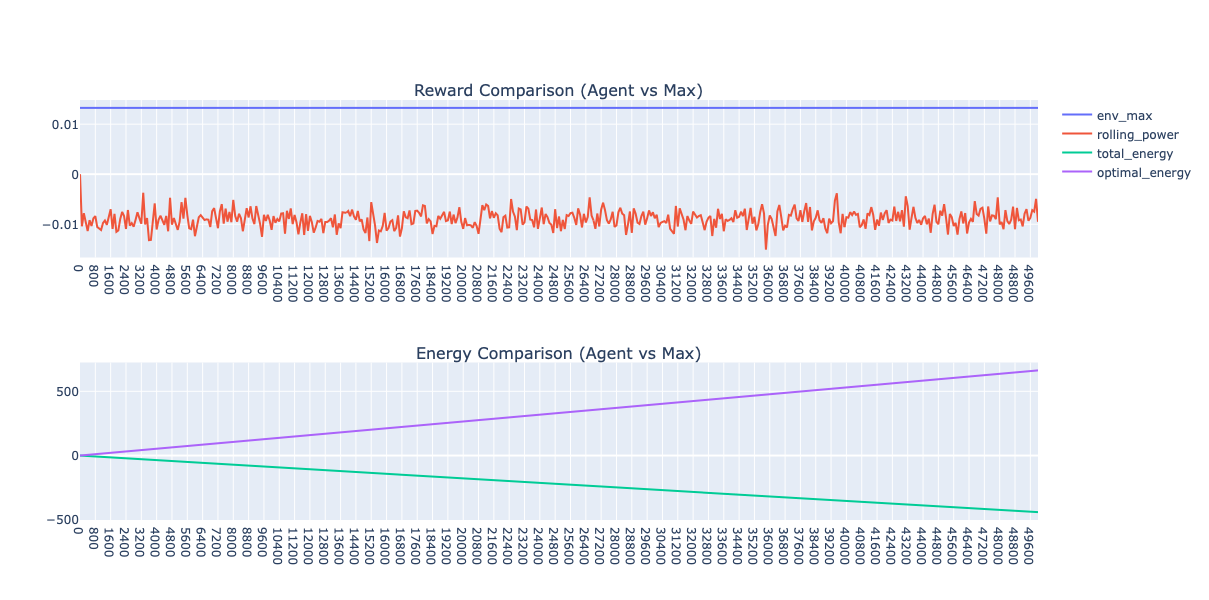

In [42]:
experiment_agent, progress_dict, progress_df = run_agent_experiment(exp_agent=experiment_agent, 
                                                                   exp_env=experiment_env, steps=steps, interval=interval)
plot_rolling_power(progress_df, experiment_env, height=600, width=600)

#### Show the agent difference from known optimal policy

#### Misc Debugging

In [ ]:
experiment_agent.get_transition_dict()

In [ ]:
experiment_agent.get_critic_array()[116]

In [ ]:
for i in range(0, 1369):
    if np.isnan(softmax_prob(experiment_agent.get_actor_array()[i], 1)[0]):
        print(i)

In [ ]:
experiment_agent.get_actor_array()[116]

In [ ]:
softmax_prob(experiment_agent.get_actor_array()[116], 1)

#### Plotting

In [ ]:
plot_rolling_power(progress_df, experiment_env, height=600, width=600)

#### Visualize state visits and learned values

In [ ]:
do_max_step = True
specific_step = '5000'

State visits

In [ ]:
px.imshow(progress_dict[(specific_step if not do_max_step else str(steps))]['state_visits'], width=width_plot, height=height_plot)

State values

In [ ]:
print(convert_2d_index_to_1d_index((10,24)))

In [ ]:
px.imshow(progress_dict[(specific_step if not do_max_step else str(steps))]['state_value'], width=700, 
          height=700, zmin=zmin_plot, zmax=zmax_plot)

**Action Probabilities**

In [ ]:
px.imshow(progress_dict[(specific_step if not do_max_step else str(steps))]['action_prob'], width=700, 
          height=700, zmin=None, zmax=None)

#### Environment True Value

In [ ]:
px.imshow(experiment_env.get_reward_array(), width=width_plot, height=height_plot)

In [ ]:
plot_array_evolution(progress_dict, interval, 'state_visits', width_plot, height_plot)

#### Visulaize evolution of learned state value

In [ ]:
plot_array_evolution(progress_dict, interval, 'state_value', width_plot, height_plot, zmax_plot, zmin_plot)

In [ ]:
# MSE vs steps
px.scatter(progress_df, x='step', y='rolling_power', width=width_plot, height=height_plot)

----
----

## Older Arduino Functions to Scan Space

In [ ]:
# Request codes
MOTOR_CONTROL = 1000
STATE_REQUEST = 2000
RESET_CODE = 6666

def scan_space(arduino):
    # Run start
    run_start = time.time()
    data_dict_list = []
    last_motor_interval = 0
    last_measure_interval = -1
    motor_frequency = 2
    measure_frequency = 1
    # Set timeouts
    abort = False
    
    for xy_degree in range(0, 181, 5):
        for yz_degree in range(0, 181, 5):
            si.write_serial_line(arduino, [MOTOR_CONTROL, xy_degree, yz_degree], print_message=False)
            new_message, abort = si.listen_for_serial(arduino)
            if new_message is not None and not abort:
                data_dict_list.append(new_message)
            elif abort:
                break
            else:
                print('Empty message received without abort issue')
            time.sleep(0.1) # Wait for steady state
        if abort:
            break
        print('xy:',xy_degree,'yz:',yz_degree)
    # Write back to start state
    write_serial_line(arduino, [si.MOTOR_CONTROL, 90, 90])

    return pd.DataFrame(data_dict_list)

In [ ]:
if __name__ == '__main__':
    print('\nARDUINO CONTROL TESTING')
    print('-------------------------')
    # Initialize serial port
    print('\nIniitalizing device...')
    serial_port = '/dev/cu.usbmodem14101'
    baud_rate = 9600
    timeout = 5
    arduino = si.initialize_serial(serial_port=serial_port, baud_rate=baud_rate, timeout=timeout)
    print('\t - SUCCESS: Device initialized.')
    
    si.write_serial_line(arduino, [MOTOR_CONTROL, 90, 90])

    # Run a loop where motor position incremented every 5 seconds, print out message
    print('\nBeginning loop sequence...')
#     data = scan_space(arduino)
    print('\t - Loop complete.')

    # Add relative time to returned data and print out
#     data['t_relative'] = data['timestamp'] - data['timestamp'].iloc[0]
    print('\nData broadcasted by Arduino:\n')
    
#     data.to_csv('/Users/jackogrady/Git/rl-solar/rl_agent/simulation_data/data/run_6_kitchen_no_lights_swapped_motors.csv', index=False)

In [ ]:
print(data)

In [ ]:
write_serial_line(arduino, [1000, 180, 90])